##Libraries

In [1]:
!pip install rdkit-pypi
!pip install pillow

from google.colab import drive
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Subset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from torch.autograd import Variable
from sklearn.model_selection import KFold

nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 30.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
drive.mount('/content/drive', force_remount=False)
file_path = '/content/drive/MyDrive/Deep - HW4/BBBP.csv'
# Read CSV file into a DataFrame
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Exploring the Dataset

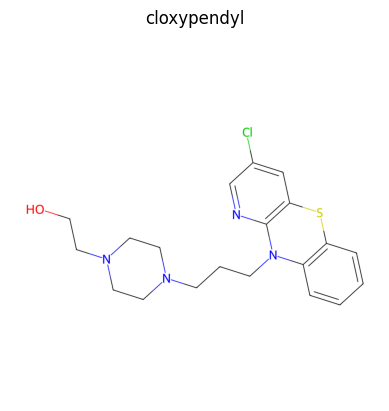

C1=C(Cl)C=NC2=C1SC4=C(N2CCCN3CCN(CCO)CC3)C=CC=C4


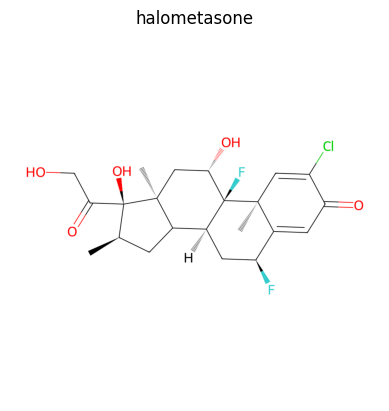

[C@H]23[C@@]([C@@]1(C(=CC(C(=C1)Cl)=O)[C@H](C2)F)C)([C@H](C[C@]4(C3C[C@H]([C@@]4(C(CO)=O)O)C)C)O)F


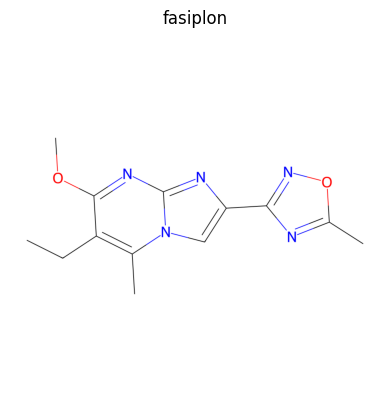

C1=C(N=C2[N]1C(=C(CC)C(=N2)OC)C)C3=NOC(=N3)C


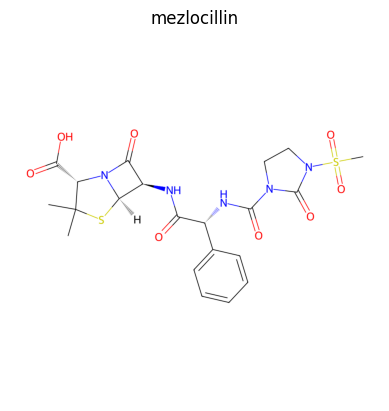

CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](NC(=O)N3CCN(C3=O)[S](C)(=O)=O)c4ccccc4)C(=O)N2[C@H]1C(O)=O


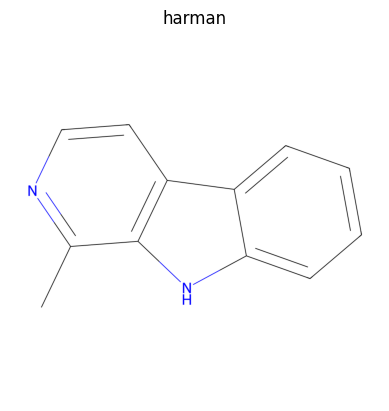

Cc1nccc2c1[nH]c3ccccc23


In [3]:
# Select 5 random rows
random_rows = df.sample(n=5)

for index, row in random_rows.iterrows():
    smiles = row['smiles']  # Assuming 'SMILES' is the column name for SMILES representation
    name = row['name']      # Assuming 'Name' is the column name for molecule names

    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=(1000, 1000))
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')
    plt.show()
    print(smiles)

plt.show()

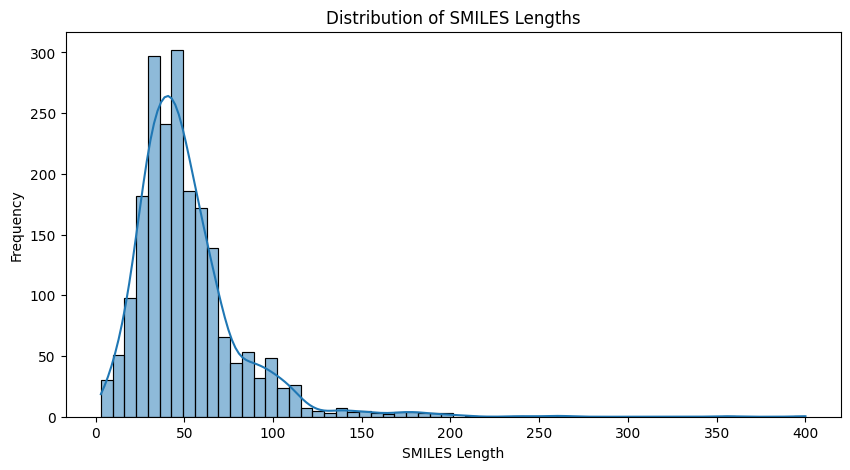

In [5]:
df['SMILES_length'] = df['smiles'].apply(lambda x: len(x))

length_distribution = df['SMILES_length'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.histplot(df['SMILES_length'], bins=60, kde=True)
plt.title('Distribution of SMILES Lengths')
plt.xlabel('SMILES Length')
plt.ylabel('Frequency')
plt.show()

The length of the molecules' smiles has a nearly guassian distribution as shown above.

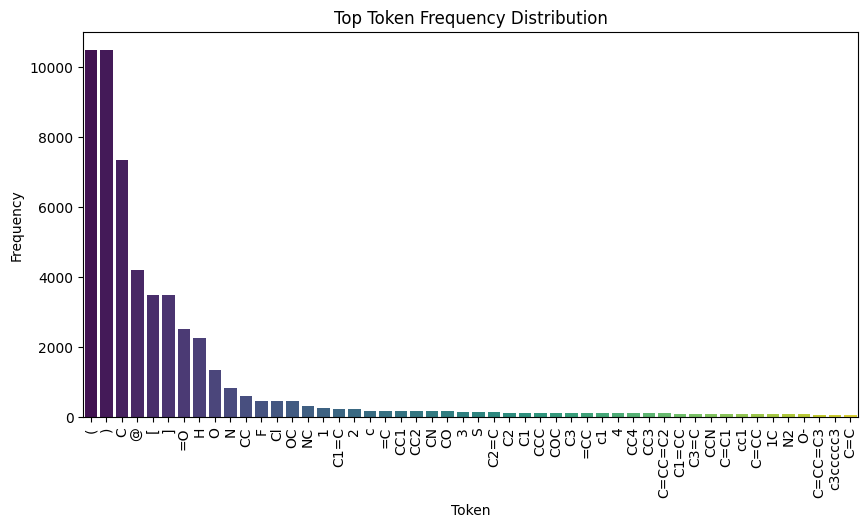

Other token's frequencies are negligible


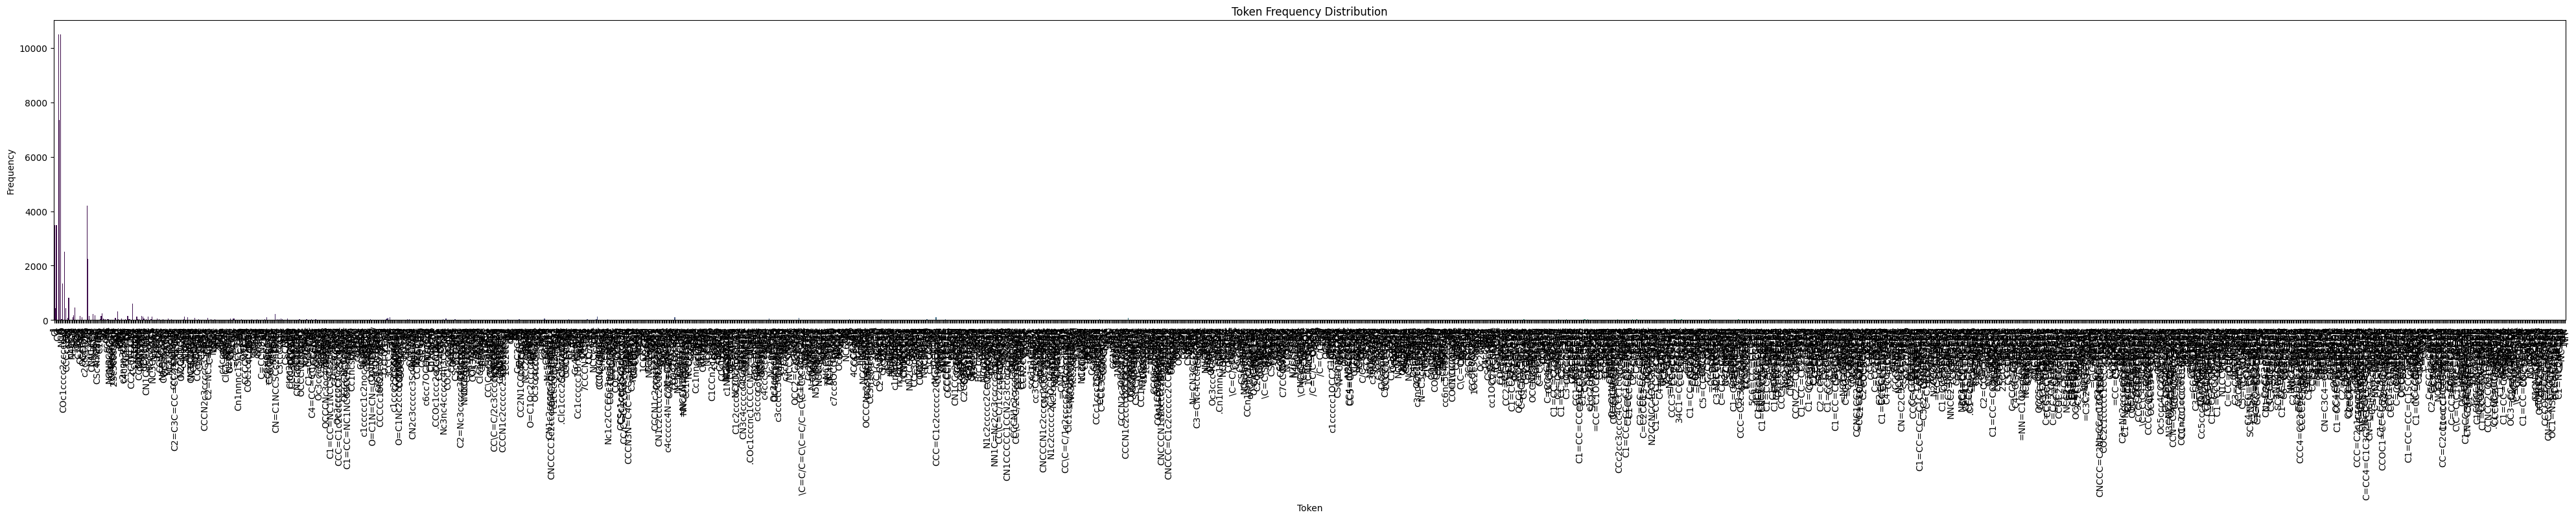

In [6]:
tokens = [word_tokenize(text) for text in df['smiles']]

# Flatten the list of tokens for proper counting
flat_tokens = [token for sublist in tokens for token in sublist]
token_distribution = Counter(flat_tokens)

# Get the top N most frequent tokens
N = 50
top_tokens = dict(sorted(token_distribution.items(), key=lambda x: x[1], reverse=True)[:N])

# Plot top N token frequency distribution
plt.figure(figsize=(10, 5))
# sns.barplot(x=list(top_tokens.keys()), y=list(top_tokens.values()), palette='viridis')
sns.barplot(x=list(top_tokens.keys()), y=list(top_tokens.values()),
            palette='viridis', hue=list(top_tokens.keys()), legend=False)
plt.title('Top Token Frequency Distribution')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

print("Other token's frequencies are negligible")

# Plotting the entire token frequency distribution that is very large
plt.figure(figsize=(50, 6))
# sns.barplot(x=list(token_distribution.keys()), y=list(token_distribution.values()), palette='viridis')
sns.barplot(x=list(token_distribution.keys()), y=list(token_distribution.values()),
            palette='viridis', hue=list(token_distribution.keys()), legend=False)
plt.title('Token Frequency Distribution')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [4]:
print(df.describe())

               num         p_np
count  2050.000000  2050.000000
mean   1027.376098     0.764390
std     592.836849     0.424483
min       1.000000     0.000000
25%     514.250000     1.000000
50%    1026.500000     1.000000
75%    1540.750000     1.000000
max    2053.000000     1.000000


Any challenges on the data is gotten taken care of in the codes

##Model Base

In [7]:
# Extract SMILES and labels
smiles = df['smiles']
labels = df['p_np']

# One-hot encode SMILES
unique_chars = set(''.join(smiles))
# print(unique_chars)
char_to_index = {char: idx for idx, char in enumerate(unique_chars)}
index_to_char = {idx: char for idx, char in enumerate(unique_chars)}

# Find the maximum sequence length
max_sequence_length = max(len(s) for s in smiles)
char_encode_length = len(unique_chars)

# Function to one-hot encode a single character
def one_hot_encode(char):
    vector = torch.zeros(len(unique_chars))
    vector[char_to_index[char]] = 1
    return vector

# Function to one-hot encode a SMILES string
def one_hot_encode_smiles(smiles):
    vectors = [one_hot_encode(char) for char in smiles]
    # Pad the vectors to the maximum sequence length
    while len(vectors) < max_sequence_length:
        vectors.append(torch.zeros(len(unique_chars)))
    return torch.stack(vectors)

# Apply one-hot encoding to all SMILES strings
encoded_smiles = torch.stack([one_hot_encode_smiles(s) for s in smiles])

# Convert to PyTorch tensors
X = encoded_smiles
y = torch.tensor(labels.values, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize model, criterion, and optimizer
# print(X_train.shape)
input_size = X_train.size(2) * X_train.size(1)
# print(input_size)
hidden_size = 64
output_size = 1  # Binary classification

Basemodel = NN(input_size, hidden_size, output_size).to(device)

In [10]:
criterion = nn.BCELoss()
optimizer = optim.Adam(Basemodel.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    Basemodel.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0


    for inputs, labels in train_loader:
        # Flatten inputs
        inputs = inputs.view(inputs.size(0), -1).to(device)

        optimizer.zero_grad()
        outputs = Basemodel(inputs)

        labels = labels.unsqueeze(1).float().to(device)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print(outputs)

        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

        total_loss += loss.item()

    # Print metrics at the end of each epoch
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/10], Loss: 0.4392, Accuracy: 0.8063
Epoch [2/10], Loss: 0.2302, Accuracy: 0.9045
Epoch [3/10], Loss: 0.1490, Accuracy: 0.9443
Epoch [4/10], Loss: 0.1056, Accuracy: 0.9610
Epoch [5/10], Loss: 0.0766, Accuracy: 0.9798
Epoch [6/10], Loss: 0.0571, Accuracy: 0.9819
Epoch [7/10], Loss: 0.0432, Accuracy: 0.9882
Epoch [8/10], Loss: 0.0326, Accuracy: 0.9930
Epoch [9/10], Loss: 0.0250, Accuracy: 0.9972
Epoch [10/10], Loss: 0.0201, Accuracy: 0.9979


In [11]:
def Baseeval(Basemodel, test_loader, printt = False):

    Basemodel.eval()

    # Lists for predictions and true labels
    all_predictions, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Forward pass
            inputs = inputs.view(inputs.size(0), -1).to(device)

            # Make predictions
            outputs = Basemodel(inputs)

            labels = labels.unsqueeze(1).float().to(device)

            predictions = (outputs > 0.5).float().cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu().numpy())

    all_predictions, all_labels = np.array(all_predictions), np.array(all_labels)

    # Print classification report
    if(printt):
      print("Classification Report:\n", classification_report(all_labels, all_predictions))

    return accuracy_score(all_labels, all_predictions)

# Calculate and print accuracy
accuracy = Baseeval(Basemodel, test_loader, True)
print(f"Accuracy: {accuracy:.4f}")

# Save the Basemodel checkpoint
torch.save(Basemodel.state_dict(), 'model.ckpt')

Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.71      0.71       147
         1.0       0.91      0.91      0.91       468

    accuracy                           0.86       615
   macro avg       0.81      0.81      0.81       615
weighted avg       0.86      0.86      0.86       615

Accuracy: 0.8634


The hyperparameters were tested to increase the test accuracy and avoid overfitting

##LSTM

In [13]:
# Tokenization
tokens = [word_tokenize(text.lower()) for text in df['smiles']]

# Calculate SMILES lengths
smiles_lengths = [len(text) for text in df['smiles']]

# Create 10 bins based on the SMILES lengths
bins = np.linspace(min(smiles_lengths), max(smiles_lengths), num=11)

# Create a vocabulary
word_counts = Counter(word for sentence in tokens for word in sentence)
vocabulary = {word: i+1 for i, (word, _) in enumerate(word_counts.items())}

# Encoding
encoded_texts = [[vocabulary[word] for word in text] for text in tokens]

# Padding
# Changed padding to see if it helps with the accuracy
max_length = max(len(text) for text in encoded_texts)
padded_texts = [[0]*(max_length - len(text)) + text for text in encoded_texts]
# print(padded_texts)

# Labels
label_map = {label: idx for idx, label in enumerate(set(df['p_np']))}
numeric_labels = [label_map[label] for label in df['p_np']]

# Train-test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(padded_texts, numeric_labels, df.index, test_size=0.3, random_state=42)

In [14]:
class SmilesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)  # Use torch.long for classification labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Convert to PyTorch datasets
train_dataset = SmilesDataset(X_train, y_train)
test_dataset = SmilesDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Outputs a single value
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, _) = self.lstm(x)
        hidden = hidden[-1]  # Take the last hidden state
        out = self.fc(hidden)
        out = self.sigmoid(out)
        return out.squeeze()

vocab_size = len(vocabulary) + 1  # Including padding index
embedding_dim = 100
hidden_dim = 128

LSTMmodel = LSTMModel(vocab_size, embedding_dim, hidden_dim)

In [18]:
def train(model, train_loader, num_epochs, printt=False):

  for epoch in range(num_epochs):
      model.train()
      total_loss = 0.0
      correct_predictions = 0
      total_samples = 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)

          # print(outputs.shape)
          # print(labels)
          # print(30*"#")
          # print(outputs)

          loss = criterion(outputs, labels.float())
          loss.backward()
          optimizer.step()

          predictions = (outputs > 0.5).float()
          correct_predictions += (predictions == labels).sum().item()
          total_samples += labels.size(0)

          total_loss += loss.item()

      # Print metrics at the end of each epoch
      average_loss = total_loss / len(train_loader)
      accuracy = correct_predictions / total_samples

      if(printt):
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LSTMmodel.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(LSTMmodel.parameters(), lr=0.001)

num_epochs = 10
train(LSTMmodel, train_loader, num_epochs, True)

Epoch [1/10], Loss: 0.0530, Accuracy: 0.9791
Epoch [2/10], Loss: 0.0389, Accuracy: 0.9861
Epoch [3/10], Loss: 0.0371, Accuracy: 0.9861
Epoch [4/10], Loss: 0.0193, Accuracy: 0.9944
Epoch [5/10], Loss: 0.0134, Accuracy: 0.9951
Epoch [6/10], Loss: 0.0115, Accuracy: 0.9965
Epoch [7/10], Loss: 0.0069, Accuracy: 0.9972
Epoch [8/10], Loss: 0.0056, Accuracy: 0.9965
Epoch [9/10], Loss: 0.0058, Accuracy: 0.9979
Epoch [10/10], Loss: 0.0040, Accuracy: 0.9972


In [19]:
def evaluate(model, test_loader, printt=False):

  model.eval()

  # Lists for predictions and ground truth labels
  all_predictions, all_labels = [], []

  # No need for gradient computation in evaluation mode
  with torch.no_grad():
      for inputs, labels in test_loader:
          # Forward pass to get outputs
          outputs = model(inputs.to(device))  # Ensure inputs are on the same device as the model

          # Apply threshold for binary classification and convert to CPU numpy array
          predictions = (outputs > 0.5).float().cpu().numpy()

          # Store predictions and ground truth labels
          all_predictions.extend(predictions)
          all_labels.extend(labels.cpu().numpy())

  # Convert lists to NumPy arrays for consistency
  all_predictions, all_labels = np.array(all_predictions), np.array(all_labels)

  # Calculate and print accuracy
  accuracy = accuracy_score(all_labels, all_predictions)

  # Print classification report
  if(printt):
    print("Classification Report:\n", classification_report(all_labels, all_predictions))

  # Save the model checkpoint
  torch.save(model.state_dict(), 'model.ckpt')

  return accuracy

accuracy = evaluate(LSTMmodel, test_loader, True)
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.69      0.72       147
           1       0.90      0.93      0.92       468

    accuracy                           0.87       615
   macro avg       0.83      0.81      0.82       615
weighted avg       0.87      0.87      0.87       615

Accuracy: 0.8715


##BiLSTM

In [20]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Changed LSTM to BiLSTM by setting bidirectional=True
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        # The fully connected layer
        self.fc = nn.Linear(2 * hidden_dim, 1)  # Binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.bilstm(x)
        # Concatenate the last hidden states from both directions
        hidden = torch.cat((output[:, -1, :hidden_dim], output[:, 0, hidden_dim:]), dim=1)
        out = self.fc(hidden)
        out = self.sigmoid(out)
        return out.squeeze()

BiLSTMmodel = BiLSTMModel(vocab_size, embedding_dim, hidden_dim)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BiLSTMmodel.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(BiLSTMmodel.parameters(), lr=0.001)

num_epochs = 10

train(BiLSTMmodel, train_loader, num_epochs, True)

Epoch [1/10], Loss: 0.0419, Accuracy: 0.9861
Epoch [2/10], Loss: 0.0291, Accuracy: 0.9909
Epoch [3/10], Loss: 0.0393, Accuracy: 0.9833
Epoch [4/10], Loss: 0.0292, Accuracy: 0.9902
Epoch [5/10], Loss: 0.0124, Accuracy: 0.9965
Epoch [6/10], Loss: 0.0110, Accuracy: 0.9944
Epoch [7/10], Loss: 0.0076, Accuracy: 0.9958
Epoch [8/10], Loss: 0.0076, Accuracy: 0.9979
Epoch [9/10], Loss: 0.0048, Accuracy: 0.9979
Epoch [10/10], Loss: 0.0050, Accuracy: 0.9986


In [24]:
accuracy = evaluate(BiLSTMmodel, test_loader, True)
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.72       147
           1       0.90      0.94      0.92       468

    accuracy                           0.87       615
   macro avg       0.84      0.81      0.82       615
weighted avg       0.87      0.87      0.87       615

Accuracy: 0.8748


From the molcule smiles definition, not expect much better accuracies are expected using a BiLSTM model vs. the LSTM. The reason is that the context from forward direction is enough for making accurate predictions and backward doesn't help that much on accuracy improving. smiles format contains the molcule structure in a left to right sequence.

##Cross Validation

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Dataset
dataset = SmilesDataset(padded_texts, numeric_labels)

# Parameters
k_folds = 5
batch_size = 16
num_epochs = 10

# KFold provides train/test indices to split data in train/test sets
kfold = KFold(n_splits=k_folds, shuffle=True)

vocab_size = len(vocabulary) + 1  # Including padding index
embedding_dim = 100
hidden_dim = 128

accuracies = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Sample elements randomly from a given list of ids
    train_subsampler = Subset(dataset, train_ids)
    test_subsampler = Subset(dataset, test_ids)

    # Define data loaders for training and testing data in this fold
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize model for this fold
    model = LSTMModel(vocab_size, embedding_dim, hidden_dim).to(device)

    criterion = nn.CrossEntropyLoss()  # Example criterion (change according to your needs)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train(model, train_loader, num_epochs)
    fold_accuracy = evaluate(model, test_loader)
    accuracies.append(fold_accuracy)

    print(f'Fold {fold+1} Accuracy: {fold_accuracy:.4f}')

print(30*"-")
# Print final accuracy for the model
final_accuracy = sum(accuracies) / len(accuracies)
print(f'Final LSTM Accuracy: {final_accuracy:.4f}')

# model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim)

Fold 1 Accuracy: 0.8634
Fold 2 Accuracy: 0.8780
Fold 3 Accuracy: 0.8902
Fold 4 Accuracy: 0.8683
Fold 5 Accuracy: 0.8805
------------------------------
Final LSTM Accuracy: 0.8761


In [27]:
accuracies = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Sample elements randomly from a given list of ids
    train_subsampler = Subset(dataset, train_ids)
    test_subsampler = Subset(dataset, test_ids)

    # Define data loaders for training and testing data in this fold
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize model for this fold
    model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim).to(device)

    criterion = nn.CrossEntropyLoss()  # Example criterion (change according to your needs)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train(model, train_loader, num_epochs)
    fold_accuracy = evaluate(model, test_loader)
    accuracies.append(fold_accuracy)

    print(f'Fold {fold+1} Accuracy: {fold_accuracy:.4f}')

print(30*"-")
# Print final accuracy for the model
final_accuracy = sum(accuracies) / len(accuracies)
print(f'Final BiLSTM Accuracy: {final_accuracy:.4f}')

Fold 1 Accuracy: 0.8659
Fold 2 Accuracy: 0.8927
Fold 3 Accuracy: 0.8683
Fold 4 Accuracy: 0.8829
Fold 5 Accuracy: 0.8780
------------------------------
Final BiLSTM Accuracy: 0.8776


We can see that overally the LSTM accuracy has increased compared to the base model accuracy. That was expected according to the LSTM property of handling sequence data. The same happens for the BiLSTM model having increased accuracy compared to the base model. But as explained before the BiLSTM here doesn't outperform the LSTM model because of the nature of the problem.

## Bin split

Bin 1       Baseline accuracy: 0.8281      LSTM accuracy: 0.7969      BiLSTM accuracy: 0.8281
Bin 2       Baseline accuracy: 0.7857      LSTM accuracy: 0.8286      BiLSTM accuracy: 0.8286
Bin 3       Baseline accuracy: 0.8750      LSTM accuracy: 0.8393      BiLSTM accuracy: 0.8929
Bin 4       Baseline accuracy: 0.9194      LSTM accuracy: 0.8710      BiLSTM accuracy: 0.9355
Bin 5       Baseline accuracy: 0.9474      LSTM accuracy: 0.9298      BiLSTM accuracy: 0.8596
Bin 6       Baseline accuracy: 0.8689      LSTM accuracy: 0.9344      BiLSTM accuracy: 0.9180
Bin 7       Baseline accuracy: 0.8750      LSTM accuracy: 0.8750      BiLSTM accuracy: 0.8594
Bin 8       Baseline accuracy: 0.8361      LSTM accuracy: 0.8852      BiLSTM accuracy: 0.9344
Bin 9       Baseline accuracy: 0.8276      LSTM accuracy: 0.8793      BiLSTM accuracy: 0.8448
Bin 10       Baseline accuracy: 0.8871      LSTM accuracy: 0.8871      BiLSTM accuracy: 0.8548



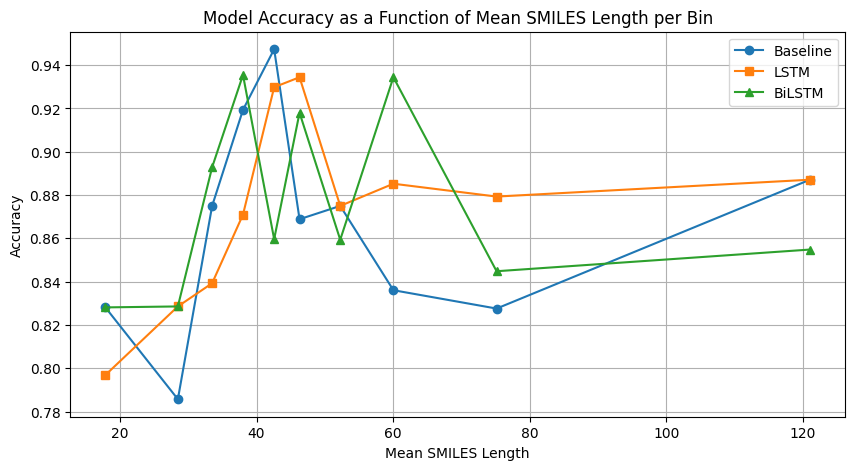

In [29]:
# Subset the DataFrame with the test indices
test_data = df.loc[idx_test]

# Split the test data into 10 bins based on 'SMILES_length'
test_data['bin'] = pd.qcut(test_data['SMILES_length'], 10, labels=False)

# Create a mapping from original DataFrame indices to indices in X_test
index_mapping = {original: i for i, original in enumerate(idx_test)}

baseline_accuracies = []
lstm_accuracies = []
bi_lstm_accuracies = []
mean_smiles_lengths = []

# Iterate over the bins for LSTM model
for bin_number in range(10):

    # print(test_data[test_data['bin'] == bin_number])
    # print(20*'-')

    # Get the indices for the current bin
    bin_indices = test_data[test_data['bin'] == bin_number].index

    # Map the original DataFrame indices to indices in X_test
    mapped_indices = [index_mapping[i] for i in bin_indices if i in index_mapping]

    # Extract the features and labels for the current bin using the mapped indices
    X_bin = [X_test[i] for i in mapped_indices]
    y_bin = [y_test[i] for i in mapped_indices]

    X_base_bin = [X[i] for i in bin_indices]
    y_base_bin = [y[i] for i in bin_indices]

    X_base_bin = torch.stack(X_base_bin)
    y_base_bin = torch.stack(y_base_bin)

    base_test_dataset = TensorDataset(X_base_bin, y_base_bin)
    base_test_loader = DataLoader(base_test_dataset, batch_size=16, shuffle=False)

    # Create a DataLoader for the current bin
    testset = SmilesDataset(X_bin, y_bin)
    test_loader = DataLoader(testset, batch_size=16, shuffle=False)

    # Evaluate the model on this DataLoader
    base_accuracy = Baseeval(Basemodel, base_test_loader)
    LSTM_accuracy = evaluate(LSTMmodel, test_loader)
    BiLSTM_accuracy = evaluate(BiLSTMmodel, test_loader)

    # Append accuracies to the lists
    baseline_accuracies.append(base_accuracy)
    lstm_accuracies.append(LSTM_accuracy)
    bi_lstm_accuracies.append(BiLSTM_accuracy)

    # Calculate and append the mean length for the current bin
    mean_length = test_data[test_data['bin'] == bin_number]['SMILES_length'].mean()
    mean_smiles_lengths.append(mean_length)

    print(f'Bin {bin_number+1}       Baseline accuracy: {base_accuracy:.4f}      LSTM accuracy: {LSTM_accuracy:.4f}      BiLSTM accuracy: {BiLSTM_accuracy:.4f}')

print()
plt.figure(figsize=(10, 5))
plt.plot(mean_smiles_lengths, baseline_accuracies, label='Baseline', marker='o')
plt.plot(mean_smiles_lengths, lstm_accuracies, label='LSTM', marker='s')
plt.plot(mean_smiles_lengths, bi_lstm_accuracies, label='BiLSTM', marker='^')
plt.xlabel('Mean SMILES Length')
plt.ylabel('Accuracy')
plt.title('Model Accuracy as a Function of Mean SMILES Length per Bin')
plt.legend()
plt.grid(True)
plt.show()

In general :

- Bins with Similar Accuracies: For some bins, all three models show similar accuracies. This could be because the sequences in these bins are either not too complex, making it easy for all models to capture the relevant patterns, or they are too complex, making it difficult for any model to perform well.

- Bins where LSTM and BiLSTM Outperform the Baseline: In bins where LSTM and BiLSTM models outperform the baseline, this suggests that the sequential nature of the data in these bins is significant and that the LSTM architectures are leveraging this to make better predictions.

- Bins where BiLSTM Outperforms LSTM: In bins where the BiLSTM model has a higher accuracy than the LSTM, this indicates that the additional context provided by processing the sequence in reverse is beneficial.

Variations in Bin Accuracies: The varying accuracy across bins indicates that the difficulty of correctly classifying sequences may depend on their lengths or other characteristics. Bins with more complex or longer sequences may challenge the LSTM's ability to retain information over long sequences, whereas the BiLSTM's bidirectional processing provides some advantage.

However we need to take into account the distribution of data over the smiles lengths plotted in data analysis part. The models performance analysis is considerable were there was enough data for training that is in the nearly 30 to 50 of the smiles' lengths.